# Approach
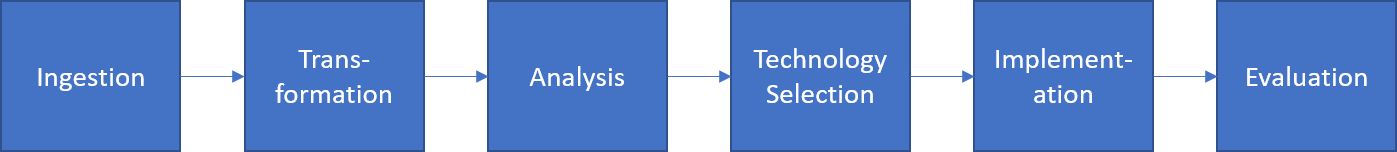


## Assumptions

1. Text comments are in English


## Notes on Related Resources

* [How AI Is Learning to Identify Toxic Online Content](https://www.scientificamerican.com/article/can-ai-identify-toxic-online-content/)
>  This is how our team built Detoxify, an open-source, user-friendly comment detection library to identify inappropriate or harmful text online. Its intended use is to help researchers and practitioners identify potential toxic comments. ... Each model can be easily accessed in one line of code and all models and training code are [publicly available on GitHub (Detoxify)]((https://github.com/unitaryai/detoxify)).

* [Detecting toxic comments with Keras and interpreting the model with ELI5](https://medium.com/@armandj.olivares/detecting-toxic-comments-with-keras-and-interpreting-the-model-with-eli5-dbe734f3e86b) - ([Github](https://github.com/ArmandDS/toxic_detection/blob/master/toxic_detection.ipynb))
> Develop an estimator with a neural network model for a text classification problem and used ELI5 library for explain the predictions



---
# Setups

In [ ]:
import os
import sys
import gc
import re
import string
import datetime
import logging
from pathlib import Path

## Global Constant

In [ ]:
# Project ID
PROJECT = "toxic_comment_classification"

# To reduce the data volumen to run through the training in short timeframe.
TEST_MODE = False

## Execution recording (e.g. 2021JUL012322)
#TIMESTAMP = datetime.datetime.now().strftime("%Y%b%d%H%M").upper()
TIMESTAMP = input("Enter TIMESTAMP") 
print(f"Execution timestamp {TIMESTAMP}")

# Directory to manage the data. 
# Place jigsaw-toxic-comment-classification-challenge.zip in DATA_DIR
DATA_DIR = "."
OUTPUT_DIR = "."

# Flag to clear data or not
CLEANING_FOR_ANALYSIS = True
CLEANING_FOR_TRAINING = False

# Flag to overwrite the cleaned data
FORCE_OVERWRITE = False

# Labbels that classifies the type of the comment.
CATEGORIES = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

Enter TIMESTAMP2021JUL08_1037
Execution timestamp 2021JUL08_1037


## Environment Specifics
### Google Colab

Google Colab specific operations.

In [ ]:
def google_colab_info():
    """Information on the Google Colab environment
    """
    # --------------------------------------------------------------------------------
    # GPU
    # --------------------------------------------------------------------------------
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
        print('and then re-execute this cell.')
    else:
        print(gpu_info)

    # --------------------------------------------------------------------------------
    # Memory
    # --------------------------------------------------------------------------------
    from psutil import virtual_memory
    ram_gb = virtual_memory().total / 1e9
    print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

    if ram_gb < 20:
        print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
        print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
        print('re-execute this cell.')
    else:
        print('You are using a high-RAM runtime!')

In [ ]:
try:
    # --------------------------------------------------------------------------------
    # Check if the environment is Google Colab.
    # --------------------------------------------------------------------------------
    import google.colab
    IN_GOOGLE_COLAB = True
    print("Using Google Colab environment.")

    # --------------------------------------------------------------------------------
    # Show Google Colab information
    # --------------------------------------------------------------------------------
    google_colab_info()

    # --------------------------------------------------------------------------------
    # Mount Google drive
    # --------------------------------------------------------------------------------
    google.colab.drive.mount('/content/drive', force_remount=True)
    
    # --------------------------------------------------------------------------------
    # Directory to manage the data
    # --------------------------------------------------------------------------------
    DATA_DIR = f"/content/drive/MyDrive/home/data/kaggle/{PROJECT}"
    PICKLE_DIR = DATA_DIR
    BASE_DIR = f"/content/drive/MyDrive/home/repository/mon/kaggle/{PROJECT}"
    OUTPUT_DIR = BASE_DIR

    # --------------------------------------------------------------------------------
    # GPU Optimized modules
    # --------------------------------------------------------------------------------
    !pip install -U spacy[cuda102]
    !python -m spacy download en_core_web_sm
    
except ModuleNotFoundError as e:
    # if str(e) == "No module named 'google.colab'":
    IN_GOOGLE_COLAB = False    
    print("Not using Google Colab environment.")

except ValueError as e:
    # https://stackoverflow.com/a/68203799/4281353
    print(f"{str(e)}: possible known issue https://stackoverflow.com/a/68203799/4281353")
    if os.path.isdir('/content/drive'):
        !ls -lrt /content/drive
        # !rm -rf /content/drive
        # google.colab.drive.flush_and_unmount()
    raise e
    

Using Google Colab environment.
Thu Jul  8 00:37:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                        

### Kaggle
* [How to detect the environment that I'm running the notebook](https://www.kaggle.com/getting-started/147177)

In [ ]:
import os
print(f"os.environ.get('KAGGLE_KERNEL_RUN_TYPE','Localhost') == '{os.environ.get('KAGGLE_KERNEL_RUN_TYPE', 'Localhost')}'")

if os.environ.get('KAGGLE_KERNEL_RUN_TYPE',''):
    print("os.environ.get('KAGGLE_KERNEL_RUN_TYPE','')                         | We are running a Kaggle Notebook/Script - Could be Interactive or Batch Mode")  
    IN_KAGGLE = True

if os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == 'Interactive':
    print("os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == 'Interactive'        | We are running a Kaggle Notebook/Script - Interactive Mode")
    IN_KAGGLE = True

if os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == 'Batch':
    print("os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == 'Batch'              | We are running a Kaggle Notebook/Script - Batch Mode")
    IN_KAGGLE = True

if os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == '':
    print("os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == ''                   | We are running code on Localhost")    
    IN_KAGGLE = False

if IN_KAGGLE:
    # --------------------------------------------------------------------------------
    # Directory to manage the data
    # --------------------------------------------------------------------------------
    DATA_DIR = "/kaggle/input/jigsaw-toxic-comment-classification-challenge"
    BASE_DIR = "/kaggle/working"
    PICKLE_DIR = BASE_DIR
    OUTPUT_DIR = BASE_DIR

    # --------------------------------------------------------------------------------
    # GPU Optimized modules
    # --------------------------------------------------------------------------------
    !pip install -U spacy[cuda102]
    !python -m spacy download en_core_web_sm

os.environ.get('KAGGLE_KERNEL_RUN_TYPE','Localhost') == 'Localhost'
os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == ''                   | We are running code on Localhost


### Localhost

In [ ]:
if (not IN_GOOGLE_COLAB) and (not IN_KAGGLE):
    !pip install h5py pandas matplotlib 
    !pip install -U spacy
    !python -m spacy download en_core_web_sm
    !python -m spacy validate

## Modules

Install and load Python modules required for the task.

In [ ]:
!pip install -U setuptools wheel
!pip install -U tensorflow transformers scikit-learn 
!pip install -U clean-text unidecode nltk wordcloud gensim
!pip install -U line_profiler memory_profiler

     |████████████████████████████████| 819kB 8.7MB/s 
Requirement already up-to-date: wheel in /usr/local/lib/python3.7/dist-packages (0.36.2)
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: setuptools 57.0.0
    Uninstalling setuptools-57.0.0:
      Successfully uninstalled setuptools-57.0.0


Requirement already up-to-date: tensorflow in /usr/local/lib/python3.7/dist-packages (2.5.0)
     |████████████████████████████████| 2.5MB 7.6MB/s 
     |████████████████████████████████| 22.3MB 59.2MB/s 
     |████████████████████████████████| 901kB 38.9MB/s 
     |████████████████████████████████| 3.3MB 42.9MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 245kB 10.4MB/s 
     |████████████████████████████████| 1.5MB 46.0MB/s 
     |████████████████████████████████| 368kB 56.0MB/s 
     |████████████████████████████████| 23.9MB 1.3MB/s 
     |████████████████████████████████| 71kB 11.3MB/s 
     |████████████████████████████████| 133kB 53.1MB/s 
  Created wheel for ftfy: filename=ftfy-6.0.3-cp37-none-any.whl size=41935 sha256=59936eba33adcbeea454bc3cfcd5b089d948fc7ed82ef9f064fbdd56db9c617d
  Stored in directory: /root/.cache/pip/whe

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc

import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import (
    WordCloud, 
    STOPWORDS
)

## Logging

Control the logging outputs to supress the warning and information to prevent the execution results from being cluttered. 

In [ ]:
logging.disable(logging.WARNING)
logging.basicConfig(level=logging.ERROR)

## Utilities


In [ ]:
SEP = ("".join((["-"] * 80))) + "\n"

# Matplotlib utilities
def plot_on_ax(ax, X, Y, label=None, color=None, title=None, xlabel=None, ylabel=None, legend=True, scale=None, limits=None):
    ax.set_xlim(limits[0:2]) if limits is not None else None
    ax.set_ylim(limits[2:4]) if limits is not None else None
    ax.set_xlabel(xlabel) if xlabel else ...
    ax.set_ylabel(ylabel) if ylabel else ...
    ax.set_title(title) if title is not None else ...
    ax.plot(X, Y, color=color, label=label)
    ax.legend() if legend else None
    ax.grid(which='major', b=False, linestyle='--')
    ax.grid(which='minor', alpha=0.2, linestyle='--')
    ax.set_xscale(scale) if scale else ...
    ax.xaxis.get_ticklocs(minor=True)
    ax.minorticks_on()

def hist_on_ax(ax, X, Y, label=None, color=None, alpha=0.5, title=None, xlabel=None, ylabel=None, legend=True, scale=None, limits=None):
    ax.set_xlim(limits[0:2]) if limits is not None else None
    ax.set_ylim(limits[2:4]) if limits is not None else None
    ax.set_xlabel(xlabel) if xlabel else ...
    ax.set_ylabel(ylabel) if ylabel else ...
    ax.set_title(title) if title is not None else ...
    ax.hist(Y, bins=X, alpha=alpha, color=color,label=label)
    ax.grid(which='both')
    ax.grid(which='major', b=False, linestyle='--')
    ax.grid(which='minor', alpha=0.2, linestyle='--')
    ax.legend() if legend else None
    ax.set_xscale(scale) if scale else ...

def plotter(ax, x, hy, uy, hcolor, ucolor, hlabel, ulabel, xlabel, ylabel, title, limits=None, single=False):
    plot_on_ax(ax, x, hy, color=hcolor, label=hlabel, xlabel=xlabel, ylabel=ylabel, title=title, limits=limits)
    plot_on_ax(ax, x, uy, color=ucolor, label=ulabel) if not single else None
    return
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)       
    plt.title(title, fontsize=20)
    plt.grid()
    ax.legend() if legend else None
    plt.axis(limits) if limits is not None else None

## Jupyter Notebook

Jupyter cell format configurations. Align the cell output to the left.

In [ ]:
%%html
<style>
table {float:left}
</style>

np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(linewidth=1000) 

## Text Processing

In [ ]:
from cleantext import clean
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


## Pandas

In [ ]:
import pandas as pd
pd.options.display.max_colwidth = 1000   # Allow long string content in a cell

## TensorFlow

Control TensorFlow logging.

| TF_CPP_MIN_LOG_LEVEL | Description|          
| - |------------- | 
|0| Suppress all messages are logged (default behavior)|
|1 |Suppress INFO messages are not printed|
|2 |Suppress INFO and WARNING messages are not printed|
|3 |Suppress INFO, WARNING, and ERROR messages are not printed|



In [ ]:
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## Transformers

[HuggingFace](https://huggingface.co/transformers/) offers the libarary for NLP (Natural Language Processing) based on the Transfoemer architecture introduced in the paper [Attention Is All You Need](https://arxiv.org/abs/1706.03762) by Google.

> Transformers provides general-purpose architectures (BERT, GPT-2, RoBERTa, XLM, DistilBert, XLNet…) for Natural Language Understanding (NLU) and Natural Language Generation (NLG) with over 32+ pretrained models in 100+ languages and deep interoperability between Jax, PyTorch and TensorFlow.

### Transfer Learning (Fine-Tuning)

Utilize the [Sequence Classification](https://huggingface.co/transformers/task_summary.html#sequence-classification) capabilty of BERT for the text classification by fine-tuing the pre-trained BERT model upon the data provided. 

* [Fine-tuning a pretrained model](https://huggingface.co/transformers/training.html)
> How to fine-tune a pretrained model from the Transformers library. In TensorFlow, models can be directly trained using Keras and the fit method. 

* [Fine-tuning with custom datasets](https://huggingface.co/transformers/custom_datasets.html)
> This tutorial will take you through several examples of using 🤗 Transformers models with your own datasets.

* [HuggingFace Text classification examples](https://github.com/huggingface/transformers/tree/master/examples/tensorflow/text-classification)
> This folder contains some scripts showing examples of text classification with the hugs Transformers library. 

The code in this notebook is based on the [run_text_classification.py](https://github.com/huggingface/transformers/blob/master/examples/tensorflow/text-classification/run_text_classification.py) example for TensorFlow and the code in the documentation [Fine-tuning with custom datasets](https://huggingface.co/transformers/custom_datasets.html).

In [ ]:
from transformers import (
    PreTrainedModel,
    DistilBertTokenizerFast,
    TFDistilBertForSequenceClassification,
    TFTrainer,
    TFTrainingArguments
)

# --------------------------------------------------------------------------------
# Control log level (https://huggingface.co/transformers/main_classes/logging.html)
# --------------------------------------------------------------------------------
os.environ['TRANSFORMERS_VERBOSITY'] = "error"
import transformers
transformers.logging.set_verbosity(transformers.logging.ERROR)

## Output Directories

In [ ]:
# Result output directory
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)
RESULT_DIRECTORY = f"{OUTPUT_DIR}/toxicity_classification_{TIMESTAMP}"
Path(RESULT_DIRECTORY).mkdir(parents=True, exist_ok=True)

if not os.access(RESULT_DIRECTORY, os.W_OK):
    raise RuntimeError(f"{RESULT_DIRECTORY} not writable")
if not os.access(PICKLE_DIR, os.W_OK):
    raise RuntimeError(f"{PICKLE_DIR} not writable")

print(f"DATA_DIR: {DATA_DIR}")
print(f"BASE_DIR: {BASE_DIR}")
print(f"OUTPUT_DIR: {OUTPUT_DIR}")
print(f"RESULT_DIRECTORY: {RESULT_DIRECTORY}")

DATA_DIR: /content/drive/MyDrive/home/data/kaggle/toxic_comment_classification
BASE_DIR: /content/drive/MyDrive/home/repository/mon/kaggle/toxic_comment_classification
OUTPUT_DIR: /content/drive/MyDrive/home/repository/mon/kaggle/toxic_comment_classification
RESULT_DIRECTORY: /content/drive/MyDrive/home/repository/mon/kaggle/toxic_comment_classification/toxicity_classification_2021JUL08_1037


---
# Ingenstion



## Data
### DATA_PATH
**DATA_PATH** variable points to the location of the data package for [Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data) in the Google Drive or in the local directory. Unzip the data package to extract the data for training and testing.

* train.csv
* test.csv
* test_labels.csv - 0/1 binary labels to identify the comment is rated for each category (e.g. toxici).

In [ ]:
if IN_GOOGLE_COLAB:
    DATA_PATH=f"{DATA_DIR}/jigsaw-toxic-comment-classification-challenge.zip"
elif IN_KAGGLE:
    pass
else:
    DATA_PATH = input("Enter the data archive path") 

In [ ]:
if not IN_KAGGLE:
    !unzip -o $DATA_PATH -d $DATA_DIR || echo

!unzip -o $DATA_DIR/train.csv.zip -d .
!unzip -o $DATA_DIR/test.csv.zip -d .
!unzip -o $DATA_DIR/test_labels.csv.zip -d .

Archive:  /content/drive/MyDrive/home/data/kaggle/toxic_comment_classification/jigsaw-toxic-comment-classification-challenge.zip
  inflating: /content/drive/MyDrive/home/data/kaggle/toxic_comment_classification/sample_submission.csv.zip  
  inflating: /content/drive/MyDrive/home/data/kaggle/toxic_comment_classification/test.csv.zip  
  inflating: /content/drive/MyDrive/home/data/kaggle/toxic_comment_classification/test_labels.csv.zip  
  inflating: /content/drive/MyDrive/home/data/kaggle/toxic_comment_classification/train.csv.zip  
Archive:  /content/drive/MyDrive/home/data/kaggle/toxic_comment_classification/train.csv.zip
  inflating: ./train.csv             
Archive:  /content/drive/MyDrive/home/data/kaggle/toxic_comment_classification/test.csv.zip
  inflating: ./test.csv              
Archive:  /content/drive/MyDrive/home/data/kaggle/toxic_comment_classification/test_labels.csv.zip
  inflating: ./test_labels.csv       


## Raw Dataframes

Load the original data from the CSV files into ```raw_``` dataframes.

* raw_train is from train.csv
* raw_test is merged from test.csv and test_labels.csv

In [ ]:
def load_raw_data(test_mode=False):
    raw_train = pd.read_csv("./train.csv")
    raw_test_data = pd.read_csv("./test.csv")
    raw_test_label = pd.read_csv("./test_labels.csv")
    raw_test = pd.merge(raw_test_data, raw_test_label, left_on='id', right_on='id', how='inner')
    del raw_test_data, raw_test_label

    if test_mode:
        raw_train = raw_train.head(256)
        raw_test = raw_test.head(128)

    return raw_train, raw_test

raw_train, raw_test = load_raw_data(TEST_MODE)
print(f"raw_train records: {raw_train['id'].count()} raw_test records: {raw_test['id'].count()}")

raw_train records: 159571 raw_test records: 153164


### Raw data (train.csv)

In [ ]:
# If in Google colab runtime and got an error, restart the runtime.
# "AttributeError: 'NotebookFormatter' object has no attribute 'get_result'""
# https://stackoverflow.com/questions/66412776
raw_train.head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0


In [ ]:
raw_train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
raw_train[raw_train['toxic'] > 0].head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,0005c987bdfc9d4b,"Hey... what is it..\n@ | talk .\nWhat is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?\n\nAsk Sityush to clean up his behavior than issue me nonsensical warnings...",1,0,0,0,0,0
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming back! Tosser.",1,0,0,0,0,0


### Raw data (test.csv)
Remove the rows where the label value is -1 as as the meaning is not clearly defined.

> test_labels.csv - labels for the test data; value of -1 indicates it was not used for scoring

In [ ]:
#raw_test.describe()
raw_test[(raw_test['toxic'] >= 0)].describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,63978.000000,63978.000000,63978.000000,63978.000000,63978.000000,63978.000000
mean,0.095189,0.005736,0.057692,0.003298,0.053565,0.011129
std,0.293478,0.075522,0.233161,0.057334,0.225160,0.104905
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
raw_test[(raw_test['toxic'] >= 0)].head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0001ea8717f6de06,Thank you for understanding. I think very highly of you and would not revert without discussion.,0,0,0,0,0,0
7,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0
11,0002f87b16116a7f,"""::: Somebody will invariably try to add Religion? Really?? You mean, the way people have invariably kept adding """"Religion"""" to the Samuel Beckett infobox? And why do you bother bringing up the long-dead completely non-existent """"Influences"""" issue? You're just flailing, making up crap on the fly. \n ::: For comparison, the only explicit acknowledgement in the entire Amos Oz article that he is personally Jewish is in the categories! \n\n """,0,0,0,0,0,0


---
# Transformation


In [ ]:
# Keep the raw non-mutated whereas train/test are mutated.
train = raw_train.copy()
test = raw_test.copy()

# To avoid OOM, remove raw_train but keep raw_test for testing/submissin.
del raw_train   
gc.collect()

281

## Enrichment
### Unhealthiness label 

Use the sum of labels as the unhealthiness level of the comment (0: healthy, 6: the most unhealthy). The ```unhealthiness``` is 2 for a comment labeled as ```toxic``` and ```insult```.

In [ ]:
train['unhealthiness'] = train.iloc[:, 1:].sum(axis=1)
train['unhealthy'] = train['unhealthiness'].apply(lambda x: int(x > 0))

### Comment length
Add the comment length to analyze the co-relation the content with its length.

In [ ]:
train['length'] = train['comment_text'].apply(lambda x: len(x))


### Data Argumentation (**Not implemented**)

Permutate the data to provide additional data and address the skewness of the data representation.

* [Data Augmentation in NLP
](https://towardsdatascience.com/data-augmentation-in-nlp-2801a34dfc28) - nlpaug
> We explore different authors how they leverage augmentation to tickle NLP tasks via generating more text data to boost up the models.  

* Github [nlpaug](https://github.com/makcedward/nlpaug)
> This python library helps you with augmenting nlp for your machine learning projects. Visit this introduction to understand about Data Augmentation in NLP. Augmenter is the basic element of augmentation while Flow is a pipeline to orchestra multi augmenter together.


## Cleaning

### De-contraction

Restore contraction (e.g. I'll) into de-contracted form (I will) to have the valid words in place.

### Stop words removal

Remove the stop words (e.g. EOL, an, the, us) that has neither positive nor negative influence on the sentence.

* EOL (End of line)
* Numbers, digits
* Email, URL, phone number, currency symbols
* Optional

### Lemmatization
Reducing the inflectional forms (e.g. having, had, has) of a word into its base (have) to focus on the core meaning, not the form of the words.

### Case consistency
Lower the case to remove variations of the same word.


In [ ]:
def decontracted(sentences):
    """Restore the contracted words"""
    # specific
    sentences = re.sub(r"won\'t", "will not", sentences, flags=re.IGNORECASE)
    sentences = re.sub(r"can\'t", "can not", sentences, flags=re.IGNORECASE)
    # general
    sentences = re.sub(r"n\'t", " not", sentences, flags=re.IGNORECASE)
    sentences = re.sub(r"\'re", " are", sentences, flags=re.IGNORECASE)
    sentences = re.sub(r"\'s", " is", sentences, flags=re.IGNORECASE)
    sentences = re.sub(r"\'d", " would", sentences, flags=re.IGNORECASE)
    sentences = re.sub(r"\'ll", " will", sentences, flags=re.IGNORECASE)
    sentences = re.sub(r"\'t", " not", sentences, flags=re.IGNORECASE)
    sentences = re.sub(r"\'ve", " have", sentences, flags=re.IGNORECASE)
    sentences = re.sub(r"\'m", " am", sentences, flags=re.IGNORECASE)
    return sentences

def remove_noises(sentences):
    """Clean up noises in the text
    Not use no_punct as it is too slow
    """
    sentences = clean(sentences,
        fix_unicode=True,               # fix various unicode errors
        to_ascii=True,                  # transliterate to closest ASCII representation
        lower=True,                     # lowercase text
        no_line_breaks=True,            # fully strip line breaks as opposed to only normalizing them
        no_urls=True,                   # replace all URLs with a special token
        no_emails=True,                 # replace all email addresses with a special token
        no_phone_numbers=True,          # replace all phone numbers with a special token
        no_numbers=True,                # replace all numbers with a special token
        no_digits=True,                 # replace all digits with a special token
        no_currency_symbols=True,       # replace all currency symbols with a special token
        no_punct=False,                 # remove punctuations
        replace_with_punct="" ,         # instead of removing punctuations you may replace them
        replace_with_url="<URL>",
        replace_with_email="<EMAIL>",
        replace_with_phone_number="<PHONE>",
        replace_with_number="",
        replace_with_digit="",
        replace_with_currency_symbol="",
        lang="en"                       # set to 'de' for German special handling
    )
    # --------------------------------------------------------------------------------
    # Remove punctuations
    # --------------------------------------------------------------------------------
    punctuation = re.escape(string.punctuation)
    pattern = '[%s%s]+' % (punctuation, r'\s')
    sentences = re.sub(pattern, " ", sentences)  
    return sentences

lemmatizer = WordNetLemmatizer()
def lemmatize(sentence):
    return " ".join([
        lemmatizer.lemmatize(word, pos="v") 
        for word in nltk.word_tokenize(sentence.lower()) 
        if word not in stopwords.words('english')
    ])

def clean_comment_text_without_lemmatize(sentences):
    return lemmatize(remove_noises(decontracted(sentences)))

def clean_comment_text(sentences):
    return lemmatize(remove_noises(decontracted(sentences)))

In [ ]:
def load_clean_data(train, test):
    train_pickle_path = f"{PICKLE_DIR}/train_lemmatized_{int(TEST_MODE)}.pkl"
    if os.path.isfile(train_pickle_path) and (not FORCE_OVERWRITE):
        del train
        gc.collect()
        train = pd.read_pickle(train_pickle_path)
    else:
        train['comment_text'] = train['comment_text'].apply(clean_comment_text)
        train.to_pickle(train_pickle_path)

    test_pickle_path = f"{PICKLE_DIR}/test_lemmatized_{int(TEST_MODE)}.pkl"
    if os.path.isfile(test_pickle_path) and (not FORCE_OVERWRITE):
        del test
        gc.collect()
        test = pd.read_pickle(test_pickle_path)
    else:
        test['comment_text'] = test['comment_text'].apply(clean_comment_text)
        test.to_pickle(test_pickle_path)
    
    return train, test

In [ ]:
if CLEANING_FOR_ANALYSIS or CLEANING_FOR_TRAINING:
    train, test = load_clean_data(train, test)

train[train['toxic'] > 0].head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,unhealthiness,unhealthy,length
6,0002bcb3da6cb337,cocksucker piss around work,1,1,1,0,1,0,4,1,44
12,0005c987bdfc9d4b,hey talk exclusive group wp talibans good destroy self appoint purist gang one ask question abt anti social destructive non contribution wp ask sityush clean behavior issue nonsensical warn,1,0,0,0,0,0,1,1,319
16,0007e25b2121310b,bye look come think comming back tosser,1,0,0,0,0,0,1,1,57


In [ ]:
if test['id'].count() >= train['id'].count():
    raise RuntimeError("Invalid counts. Verfity the train/test data.")

In [ ]:
# Drop the rows with -1. ['toxic'] >= 0 is sufficient
test = test[test['toxic'] >= 0]
test.head(3)
gc.collect()

112

In [ ]:
print(f"Train records: {train['id'].count()} Test records: {test['id'].count()}")

Train records: 159571 Test records: 63978


---
# Utility (Analysis)

In [ ]:
# Wordcloud Utilities
wc_stopwords=set(STOPWORDS)
def generate_wordcloud_image(words):
    """Generate world could image"""
    image = WordCloud(
        max_words=500, 
        min_font_size=5,
        width = 1000, 
        height = 500,
        stopwords=wc_stopwords, 
        background_color="black", 
        margin=5, 
        collocations=False,
        random_state=10
    ).generate(words)
    return image

def generate_healthy_comment_wordclouds():
    words_healthy = " ".join(train[train['unhealthiness'] == 0]["comment_text"].values)
    plt.figure(figsize=(12, 10))
    plt.title("Frequent words in Healthy comments", fontsize=25)
    plt.axis("off")
    plt.imshow(generate_wordcloud_image(words_healthy), interpolation = 'bilinear')
    del words_healthy
    
def generate_unhealthy_comment_wordclouds():
    num_cols = 2
    num_rows = len(CATEGORIES) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15,15))
    plt.axis('off')
    images = []
    for index, category in enumerate(CATEGORIES):
        image = generate_wordcloud_image(
            " ".join(train[train[category] == 1]["comment_text"].values)
        )
        images.append(image)

    for index, category in enumerate(CATEGORIES):
        row = index // num_cols
        col = index % num_cols
        ax = axes[row][col]
        ax.imshow(images[index])
        ax.set_title(
            category, 
            fontdict={'fontsize': 25, 'fontweight': 'medium'}
        )
        for pos in ['top', 'bottom', 'right', 'left']:
            ax.spines[pos].set_visible(False)
            ax.set_xticklabels([])
            ax.set_xticks([])
            ax.set_yticklabels([])
            ax.set_yticks([])

    fig.tight_layout()
    plt.show()
    del images
    del fig, axes

import collections
class WordAnalysis:
    def __init__(self, corpus):
        """Generate word indices from a text corpus
        Args:
            corpus: A string including sentences to process.
        """
        words = corpus.lower().split()
        self._total = len(words)
        assert self._total > 0

        self._counts = collections.Counter(words)
        del words
        self._word_to_probability = {
            word: (count / self._total) for (word, count) in self._counts.items()
        }

        # --------------------------------------------------------------------------------
        # Vocabulary from the keys of probabilities preserving the same word order
        # --------------------------------------------------------------------------------
        self.vocabulary = list(self._word_to_probability.keys())

    def probability(self, word):
        return self._word_to_probability.get(word.lower(), 0.0)

    def count(self, word):
        """Number of times when the word occured in the original corpus"""
        return self._counts.get(word.lower(), 0)

    def size(self):
        """Number of words in the vocabulary"""
        return len(self.vocabulary)

    def total(self):
        """Total words in the original corpus"""
        return self._total

    def top(self, n):
        """Top n most common words"""
        assert 0 < n < self._total
        return [
            (word, count/self._total)
            for (word, count) in self._counts.most_common(n)
        ]

In [ ]:
def unhealthy_volume_ration_per_length():
    """Ratio of unhealthy comments in the length ranges"""
    ratios = []
    lengths = []
    max_length = 1000
    interval = 50
    steps = range(0, max_length + 1, interval)
    for start in steps:
        stop = start + interval
        total_volume = train[
            (start <= train['length']) & (train['length'] < stop)
        ]['id'].count()
        unhealthy_volume = train[
            (start <= train['length']) & 
            (train['length'] < stop) & 
            (train['unhealthiness'] > 0)
        ]['id'].count()

        lengths.append(stop)
        ratios.append(unhealthy_volume / total_volume)

    return lengths, ratios

def run_analysis():
    """Run analysis on comment length significances"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10)) 
    bins = range(0, 1200+1, 100)
    limits=[0, 1200, 0, 40000]
    H = train[train['unhealthiness'] == 0]['length']
    U = train[train['unhealthiness'] > 0]['length']

    # --------------------------------------------------------------------------------
    # Volume / Length
    # Co-relation from length to the comment volume per healthy/unhealthy per ranges.
    # --------------------------------------------------------------------------------
    # Volume per Length
    ax_volume_length = axes[0][0]
    hist_on_ax(ax_volume_length, bins, U, label="unhealthy comment", color='r', alpha=0.9, title="Comment volume per length", xlabel='Length of comments', ylabel='Number of comments', legend=True, limits=limits)
    hist_on_ax(ax_volume_length, bins, H, label="healthy comment", color='g', alpha=0.4, title="Comment volume per length", xlabel='Length of comments', ylabel='Number of comments', legend=True, limits=limits)
    ax_volume_length.plot([200, 200], [0, 35000], linestyle='--', linewidth=2, color='r', alpha=0.5)

    # --------------------------------------------------------------------------------
    # Ratio / Length
    # Co-relation from length to unhealthy volume ratio against total volume IN the ranges.
    # This is not a cumulative volume but the volume within each specific range e.g. 
    # comment length between 100 and 200.
    # --------------------------------------------------------------------------------
    ax_ratio_length = axes[0][1]
    X, Y = unhealthy_volume_ration_per_length()
    plot_on_ax(ax_ratio_length, X, Y, label="unhealthy ratio", color='orange', title="Unhealthy comment ratio", xlabel='Length of comments', ylabel='Ratio of unhealthy comments', legend=True, limits=None)
    ax_ratio_length.plot([200, 200], [0.01, 0.17], linestyle='--', linewidth=2, color='r', alpha=0.5)

    # --------------------------------------------------------------------------------
    # Length / Percentile
    # Co-relation from percentile (total accumulative volume) to unhealthy comment length 
    # --------------------------------------------------------------------------------
    quantiles = np.linspace(.1, 1, 9, 0)
    ax_legth_percentile = axes[1][0]
    comment_length_percentil_U = U = (train[train['unhealthiness'] > 0]['length']).quantile(np.linspace(.1, 1, 9, 0), 'lower').values
    comment_length_percentil_H = H = (train[train['unhealthiness'] == 0]['length']).quantile(np.linspace(.1, 1, 9, 0), 'lower').values
    plotter(ax_legth_percentile, quantiles, H, U, 'g', 'r', "Healthy", "Unhealthy", 'Percentil', 'Comment length', "Comment length percentile", [None, None, 0, 1000], False)
    ax_legth_percentile.plot([0.05, 0.95], [200, 200], linestyle='--', linewidth=2, color='r', alpha=0.5)

    # Ratio / Percentile
    ax_ratio_percentile = axes[1][1]
    ratio = comment_length_percentil_U / comment_length_percentil_H
    plotter(ax_ratio_percentile, quantiles, ratio, None, 'k', 'r', "length ratio (unhealthy/healthy)", None, 'Percentil', 'Ratio', "Comment length Ratio", [None, None, 0, 1], True)


healthy = train[train['unhealthiness'] == 0]
unhealthy = train[train['unhealthiness'] > 0]

# --------------------------------------------------------------------------------
# Unhealthy volume ratio
# --------------------------------------------------------------------------------
start = 0
stop = 200
total_volume = train[
    (start <= train['length']) & (train['length'] < stop)
]['id'].count()
unhealthy_volume = train[
    (start <= train['length']) & 
    (train['length'] < stop) & 
    (train['unhealthiness'] > 0)
]['id'].count()
print(f"\n{SEP}Unhealthy volume ratio (<{stop}:\n{SEP}{unhealthy_volume/total_volume}\n")

# --------------------------------------------------------------------------------
# Comment length histram (bins = [1,200,400,600,800,1000,1200])
# --------------------------------------------------------------------------------
sep = ("".join((["-"] * 80))) + "\n"
print(
    f"{SEP}Histgram for Healthy comment length:\n{SEP}"
    f"{healthy.groupby(pd.cut(healthy['length'], np.arange(0, 1200, 200)))['id'].count()}"
)
print(
    f"\n{SEP}Histgram for Unhealthy comment length:\n{SEP}"
    f"{unhealthy.groupby(pd.cut(unhealthy['length'], np.arange(0, 1200, 200)))['id'].count()}"
)

# --------------------------------------------------------------------------------
# Quantiles of comment length
# --------------------------------------------------------------------------------
print(f"{SEP}Quantiles of comment length (healthy)\n{SEP[:-1]}")
print(healthy['length'].quantile(np.linspace(.1, 1, 9, 0)))

print(f"\n{SEP}Quantiles of comment length (unhealthy)\n{SEP[:-1]}")
print(unhealthy['length'].quantile(np.linspace(.1, 1, 9, 0)))

# --------------------------------------------------------------------------------
# Median comment length
# --------------------------------------------------------------------------------
print(f"{SEP}Median comment length:\n{SEP}Healthy[{healthy['length'].median()}] \nUnhealthy[{unhealthy['length'].median()}]")


--------------------------------------------------------------------------------
Unhealthy volume ratio (<200:
--------------------------------------------------------------------------------
0.13478116286803263

--------------------------------------------------------------------------------
Histgram for Healthy comment length:
--------------------------------------------------------------------------------
length
(0, 200]       67945
(200, 400]     34466
(400, 600]     15388
(600, 800]      8119
(800, 1000]     4907
Name: id, dtype: int64

--------------------------------------------------------------------------------
Histgram for Unhealthy comment length:
--------------------------------------------------------------------------------
length
(0, 200]       10560
(200, 400]      2939
(400, 600]      1082
(600, 800]       521
(800, 1000]      284
Name: id, dtype: int64
--------------------------------------------------------------------------------
Quantiles of comment length (healt

# Analysis

### Dominant words

### Objective

Overviews on the dominant words for healthy comments, and each type of healhthy comments.

### Healthy comment

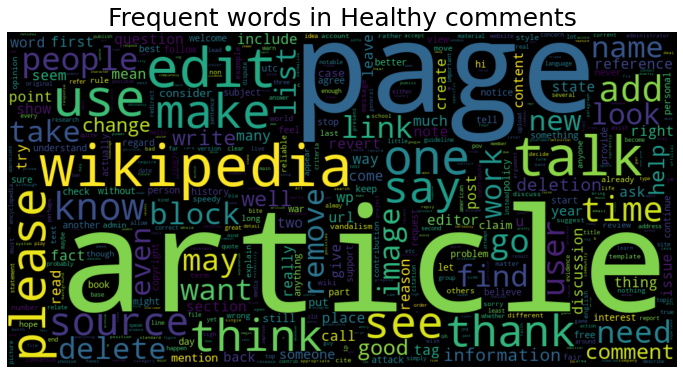

In [ ]:
generate_healthy_comment_wordclouds()

### Unhealthy  Comment

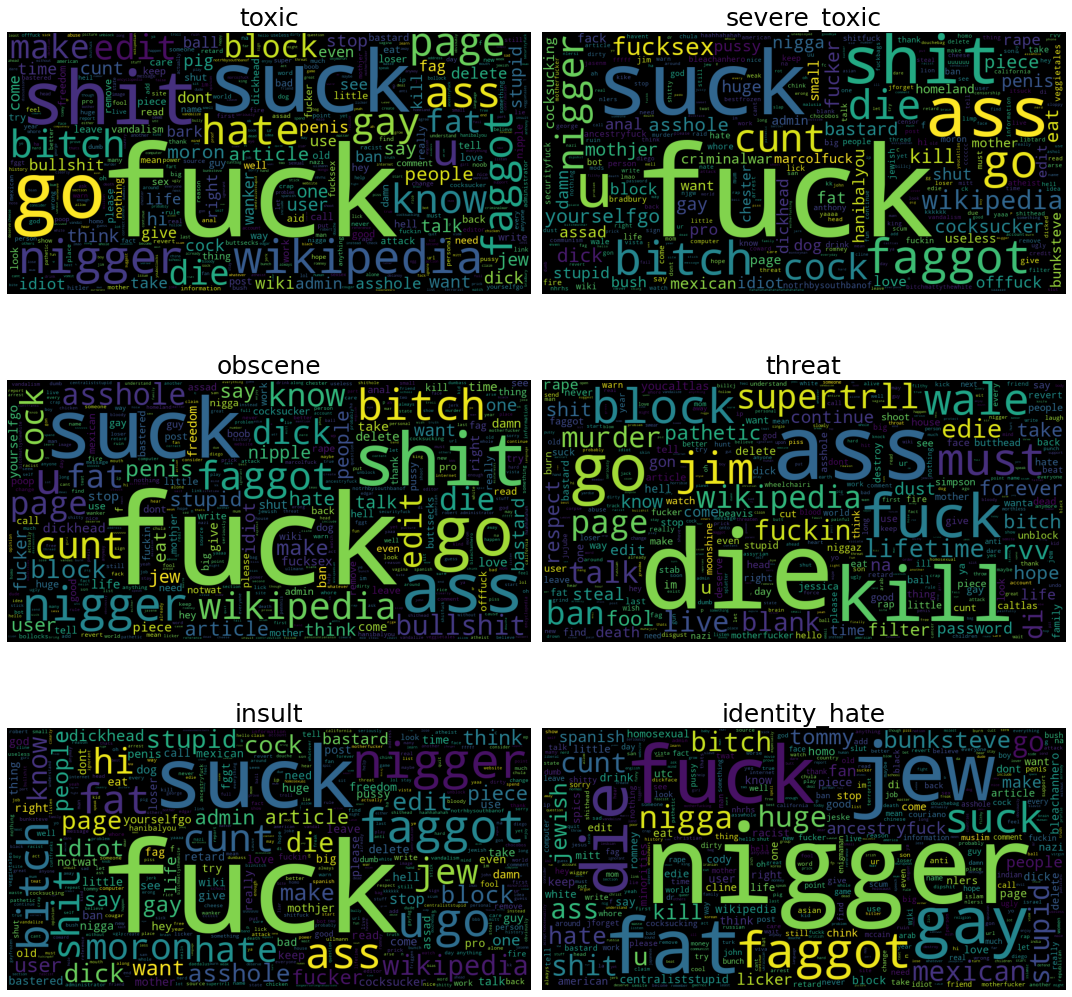

In [ ]:
generate_unhealthy_comment_wordclouds()

## Comment length

### Objective
**Co-relation** between the **length** and **healthiness** of a comment. *Healthiness* is a binary classification either a comment is healthy or unhealthy where "unhealthy" comments are those labeled as toxic, insult, etc.

### Findings

> * ***Unhealthy*** comments tend to be **short**. 
> * Approx 13.5% of total comments shorter than **200** are unhealthy.
> * Approx 65% of unhealthy comments are shorter than **200**. 


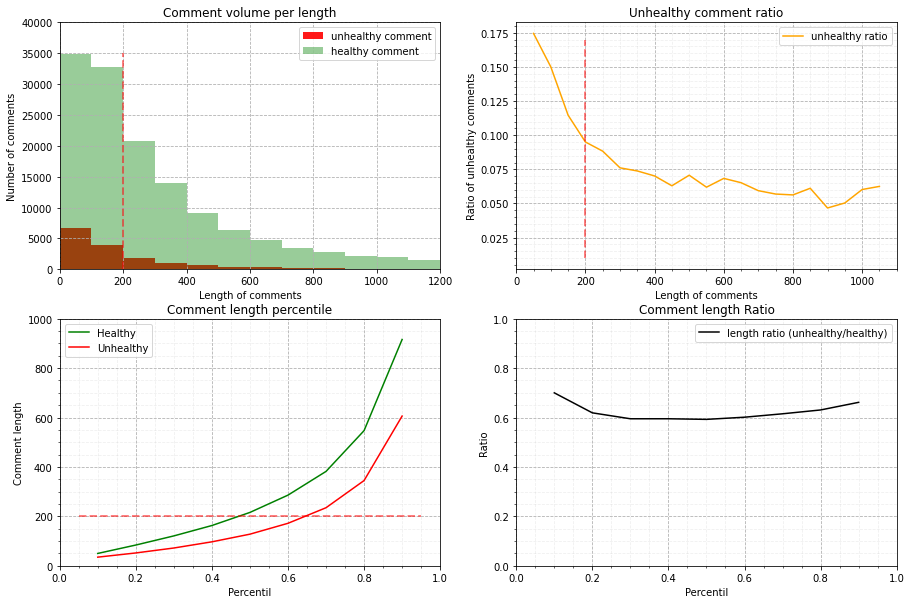

In [ ]:
run_analysis()


### Action

> * Focus on the comments shorter than **200**.
> * **A/B test** for comment length requirement - A for minimum comment length and B for none.<BR>

Comment length requirement may discourage providing comments. However those who have the intention to contribute would still proceed, hence improving the quality of the comments.

### Further Considerations

* Analysi per the label type - What differentiates the comment classified as **(toxic and insult)** from **(toxic not insult)**, etc.


## Utility (Vocabulary)

In [ ]:
clean = WordAnalysis(" ".join(train[train['unhealthy'] == 0]['comment_text'].values))
dirty = WordAnalysis(" ".join(train[train['unhealthy'] > 0]['comment_text'].values))

def show_alert_words():
    words_only_in_dirty = set(dirty.vocabulary) - set(clean.vocabulary)
    _words = []
    for word in words_only_in_dirty:
        _words = _words + ([word] * dirty.count(word))
    filthy = WordAnalysis(" ".join(_words))
    image_filthy_words = generate_wordcloud_image(" ".join(_words))
    del _words

    n = 10
    print("--------------------------------------------------------------------------------")
    print(f"Top {n} most used alert words in unhealthy comments")
    print("--------------------------------------------------------------------------------")
    for word, ratio in filthy.top(n):
        print(f"{word:20s} {ratio:0.5f}")

    plt.figure(figsize=(12, 10))
    plt.title("Words only in unhealthy comments", fontsize=30)
    plt.axis("off")
    plt.imshow(image_filthy_words, interpolation = 'bilinear')
    del image_filthy_words

def show_divine_words():
    words_only_in_clean = set(clean.vocabulary) - set(dirty.vocabulary)
    _words = []
    for word in words_only_in_clean:
        _words = _words + ([word] * clean.count(word))
    divine = WordAnalysis(" ".join(_words))
    image_divine_words = generate_wordcloud_image(" ".join(_words))
    del _words

    n = 10
    print("--------------------------------------------------------------------------------")
    print(f"Top {n} most used divine words in healthy comments")
    print("--------------------------------------------------------------------------------")
    for word, ratio in divine.top(n):
        print(f"{word:20s} {ratio:0.5f}")

    plt.figure(figsize=(12, 10))
    plt.title("Words only in healthy comments", fontsize=35)
    plt.axis("off")
    plt.imshow(image_divine_words, interpolation = 'bilinear')
    del image_divine_words

def show_more_frequent_words_than_normal():
    _ratio = 10.0
    words_common = set.intersection(set(dirty.vocabulary), set(clean.vocabulary))
    _words = [
        word for word in words_common 
        if dirty.probability(word) / clean.probability(word) > _ratio
    ]
    _image_more_frequent_words = generate_wordcloud_image(" ".join(_words))

    plt.figure(figsize=(12, 10))
    plt.title("Words more frequent in unhealthy comments", fontsize=30)
    plt.axis("off")
    plt.imshow(_image_more_frequent_words, interpolation = 'bilinear')
    del _words
    del _image_more_frequent_words

x = 0.0
for word in clean.vocabulary:
    x += dirty.probability(word)
print(f"[{(1.0 - x) * 100:2.2f}] % of the words in unhealthy comments are only used in there.")

x = 0.0
for word in dirty.vocabulary:
    x += clean.probability(word)
print(f"[{(1.0 - x) * 100:2.2f}] % of the words in healthy comments are only used in there.")

[5.13] % of the words in unhealthy comments are only used in there.
[7.91] % of the words in healthy comments are only used in there.


## Vocabulary

### Objective

**Co-relation** between the certain **vocabulary** to the **healthiness** of a comment. Healthiness is a binary classification either a comment is healthy or unhealthy where "unhealthy" comments are those labeled as toxic, insult, etc.

### Findings

> * The **Foul words** would directly identify unhealthy comments. Those **6.57 %** of the unhealthy words never occurrs in healthy comments.
> * The **Alert words** would help identify unhealthy comments. Those words occurres **10** times more in unhealthy comments than healthy ones.
> * The **divine words** would directly identify healthy comments. Those **9.54 %** of the healthy words never occurrs in unhealthy comments.


### Foul Words

--------------------------------------------------------------------------------
Top 10 most used alert words in unhealthy comments
--------------------------------------------------------------------------------
fucksex              0.02631
yourselfgo           0.02618
cocksucker           0.02319
buttsecks            0.02100
mothjer              0.02062
fggt                 0.02011
notwat               0.01982
bastered             0.01893
hanibalyou           0.01543
offfuck              0.01518


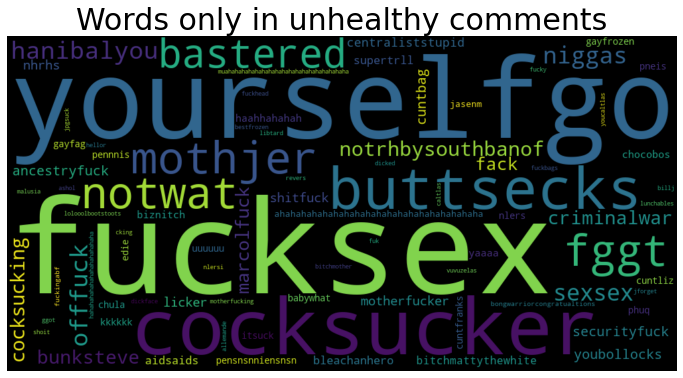

In [ ]:
show_alert_words()

### Alert Words

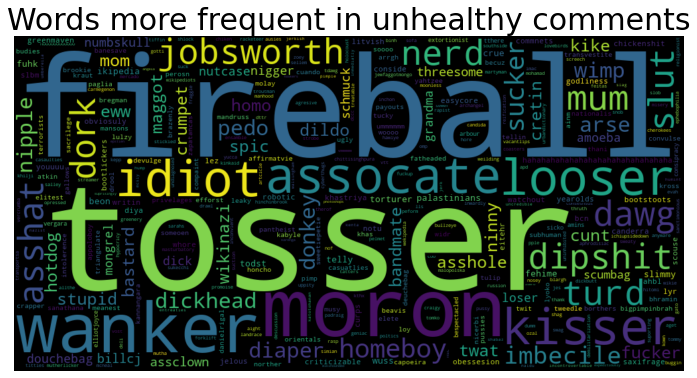

In [ ]:
show_more_frequent_words_than_normal()

### Divine Words

Skipped due to the resource consumption restriction.

--------------------------------------------------------------------------------
Top 10 most used divine words in healthy comments
--------------------------------------------------------------------------------
ffffa                0.00180
philippineslong      0.00106
newsletter           0.00103
cellpadding          0.00094
nikko                0.00090
wizard               0.00085
deneid               0.00083
replaceable          0.00082
pagedelete           0.00079
lawdy                0.00079


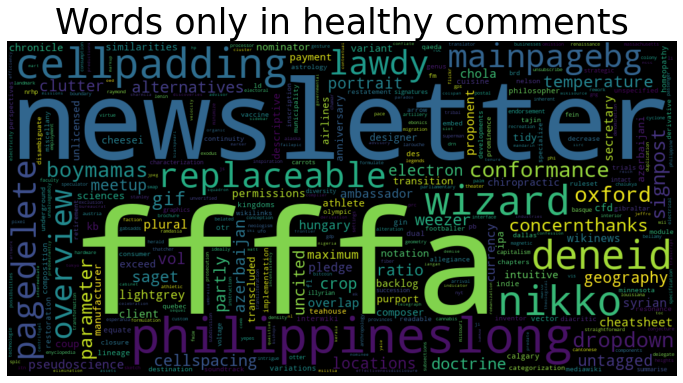

In [ ]:
# Takes too long
show_divine_words()


### Actions

> * Filter those comments including the **foul words** 
> * Raise cases to investigate into comments including the **alert words**

### Further Considerations

* Capital letters - 
Offensive comments can include more capital letters e.g. NONSENSE!

* Exclamation marks - 
Offensive comments can include more exclamation usages e.g. NONSENSE!!!!

* Imperative forms - The offensive comments can be more directive.

* Emoji - Healthy comments can include more emoji e.g. 🤗 

ML would be a good option to find such patterns from the text comments.



## Vocabulary Size

### Objective
Correlation from the variety of the vocabulary to the healthiness of a comment. 

### Findings
> * Significantly **less vocabulary** is used in the unhealthy comments.

### Actions

TBD. Need further analysis.

Vocaburary size healthy[146832] unhealthy[29135]


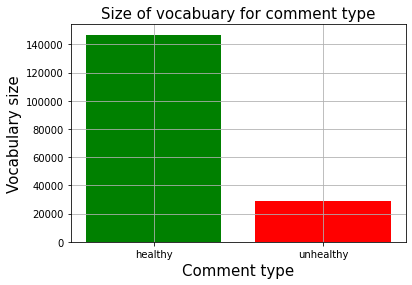

In [ ]:
print(f"Vocaburary size healthy[{clean.size()}] unhealthy[{dirty.size()}]")
plt.bar(["healthy", "unhealthy"], [clean.size(), dirty.size()], color = ['green','red'])
plt.xlabel('Comment type', fontsize=15)
plt.ylabel('Vocabulary size', fontsize=15)
plt.title('Size of vocabuary for comment type', fontsize=15)    
plt.grid()   

In [ ]:
del clean, dirty
gc.collect()

41287

---
# Technology Selection

What algorithms to use and what technologies are available.

## Nature of the problem

* Multi-label Binary Classification 

It is a binary classification task where multiple althorithms have been developed and applied in the real life e.g. SPAM fileter.

* Naive Bayes - [Naive Bayes and Text Classification](https://arxiv.org/abs/1410.5329)
* CNN - [Convolutional Neural Networks for Sentence Classification](https://arxiv.org/pdf/1408.5882.pdf)
* DNN Language Model - [Attention Is All You Need](https://arxiv.org/abs/1706.03762)

## Asssessment

Skipped due to the time constraint.

## Decision

**Transformer Deep Neural Network Architecture** transfer-learning (fine-tuning) on the pre-trained language model.

1. State of the art algorithms being actively researched.
2. Pre-trained models for text classification e.g text sentiment analysis are available. 
3. Other well-explored althorithms have been well tested as published in Kaggle. 










---
# Implementation



## ML Model for Fine Tuning

### Framework
* Google TensorFlow 2.x 
* Keras for training the model
* Huggingface Transformer library

### Data allocation
Utilize [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to :
1. shuffle the train data 
2. allocate the ratio R of the data for validation. R=0.2
3 apply the model training on (1-R) ratio of the data for training

Apply the trained model on testing data for evaluation.

### Hyper parameter search
* Learning rate (5e-5, 5e-4, 5e-3) as the start value

### Epoch
Number of times to go through the entire training data set N. N=10 due to the time constraint.

### Early stopping
Utilize Keras [EarlyStopping](https://keras.io/api/callbacks/early_stopping/) to stop the training when no improvement is achieved N times. N=5.

### Reduce learning rate at no improvement
Utilize Keras [ReduceLROnPlateau](https://keras.io/api/callbacks/reduce_lr_on_plateau/) to reduce the learning rate when no improvement is achieved N times. N=3.


### Keras Callbacks

Utilize [Keras Callbacks API](https://keras.io/api/callbacks/) to apply Eary Stopping, Reduce Learning Rate, and TensorBoard during the model training.



In [ ]:
class SavePretrainedCallback(tf.keras.callbacks.Callback):
    """
    This is only for directly working on the Huggingface models.
    
    Hugging Face models have a save_pretrained() method that saves both 
    the weights and the necessary metadata to allow them to be loaded as 
    a pretrained model in future. This is a simple Keras callback that 
    saves the model with this method after each epoch.
    
    """
    def __init__(self, output_dir, **kwargs):
        super().__init__()
        self.output_dir = output_dir
        self.lowest_val_loss=np.inf
        self.best_epoch = -1
        self.verbose = kwargs['verbose'] if 'verbose' in kwargs else False

    def on_epoch_end(self, epoch, logs=None):
        """
        Save only the best model
        - https://stackoverflow.com/a/68042600/4281353
        - https://www.tensorflow.org/guide/keras/custom_callback
        
        TODO: 
        save_pretrained() method is in the HuggingFace model only.
        Need to implement an logic to update for Keras model saving.
        """
        val_loss=logs.get('val_loss')
        if (self.best_epoch < 0) or (val_loss < self.lowest_val_loss):
            if self.verbose:
                print(f"Model val_loss improved: [{val_loss} < {self.lowest_val_loss}]")
                print(f"Saving to {self.output_dir}")
            self.lowest_val_loss = val_loss
            self.best_epoch = epoch
            self.model.save_pretrained(self.output_dir)


class TensorBoardCallback(tf.keras.callbacks.TensorBoard):
    """TensorBoard visualization of the model training
    See https://keras.io/api/callbacks/tensorboard/
    """
    def __init__(self, output_directory):
        super().__init__(
            log_dir=output_directory,
            write_graph=True,
            write_images=True,
            histogram_freq=1,     # log histogram visualizations every 1 epoch
            embeddings_freq=1,    # log embedding visualizations every 1 epoch
            update_freq="epoch",  # every epoch
        )


class EarlyStoppingCallback(tf.keras.callbacks.EarlyStopping):
    """Stop training when no progress on the metric to monitor
    https://keras.io/api/callbacks/early_stopping/
    https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

    Using val_loss to monitor. 
    https://datascience.stackexchange.com/a/49594/68313
    Prefer the loss to the accuracy. Why? The loss quantify how certain 
    the model is about a prediction. The accuracy merely account for 
    the number of correct predictions. Similarly, any metrics using hard 
    predictions rather than probabilities have the same problem.
    """
    def __init__(self, patience=3):
        assert patience > 0
        super().__init__(
            monitor='val_loss', 
            mode='min', 
            verbose=1, 
            patience=patience,
            restore_best_weights=True
        )


class ModelCheckpointCallback(tf.keras.callbacks.ModelCheckpoint):
    """Check point to save the model
    See https://keras.io/api/callbacks/model_checkpoint/

    NOTE: Did not work with HuggingFace with the error.
        NotImplementedError: Saving the model to HDF5 format requires the model 
        to be a Functional model or a Sequential model. 
        It does not work for subclassed models, because such models are defined 
        via the body of a Python method, which isn't safely serializable. 
    """
    def __init__(self, path_to_file):
        """
        Args:
            path_to_file: path to the model file to save at check points
        """
        super().__init__(
            filepath=path_to_file, 
            monitor='val_loss', 
            mode='min', 
            save_best_only=True,
            save_freq="epoch",
            verbose=1
        )


class ReduceLRCallback(tf.keras.callbacks.ReduceLROnPlateau):
    """Reduce learning rate when a metric has stopped improving.
    See https://keras.io/api/callbacks/reduce_lr_on_plateau/
    """
    def __init__(self, patience=3):
        assert patience > 0
        super().__init__(
            monitor="val_loss",
            factor=0.2,
            patience=patience,
            verbose=1
        )


### Fine Tuning Runner

The Runner class implements the fine-tuning based on the [distilbert-base-uncased](https://huggingface.co/distilbert-base-uncased) pretrained model. Each classification category e.g. ```toxic``` will have a dedicated Runner class instance. The reason for using the ***Distilled*** BERT model is to run the training on the limited resources


In [ ]:
from tensorflow.keras.models import (
    Sequential
)
from tensorflow.keras.layers import (
    Dense
)


tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')


class Runner:
    """Fine tuning implementation class
    See:
    - https://www.tensorflow.org/guide/keras/train_and_evaluate
    - https://stackoverflow.com/questions/68172891/
    - https://stackoverflow.com/a/68172992/4281353

    The TF/Keras model has the base model, e.g distilbert for DistiBERT which is
    from the base model TFDistilBertModel.
    https://huggingface.co/transformers/model_doc/distilbert.html#tfdistilbertmodel

    TFDistilBertForSequenceClassification has classification layers added on top
    of TFDistilBertModel, hence not required to add fine-tuning layers by users.
    _________________________________________________________________
    Layer (type)                 Output Shape              Param #   
    =================================================================
    distilbert (TFDistilBertMain multiple                  66362880  
    _________________________________________________________________
    pre_classifier (Dense)       multiple                  590592    
    _________________________________________________________________
    classifier (Dense)           multiple                  1538      
    _________________________________________________________________
    dropout_59 (Dropout)         multiple                  0         
    =================================================================
    """
    # ================================================================================
    # Class
    # ================================================================================
    USE_HF_TRAINER = False
    TOKENIZER_LOWER_CASE = True
    # _model_name = 'distilbert-base-cased'
    _model_name = 'distilbert-base-uncased'
    _model_base_name = 'distilbert'
    _tokenizer = DistilBertTokenizerFast.from_pretrained(
        _model_name, 
        do_lower_case=TOKENIZER_LOWER_CASE
    )

    # ================================================================================
    # Instance
    # ================================================================================
    # --------------------------------------------------------------------------------
    # Instance properties
    # --------------------------------------------------------------------------------
    @property
    def category(self):
        """Category of the text comment classification, e.g. toxic"""
        return self._category

    @property
    def num_labels(self):
        """Number of labels to classify"""
        assert self._num_labels > 0
        return self._num_labels

    @property
    def tokenizer(self):
        """BERT tokenizer. The Tokenzer must match the pretrained model"""
        return self._tokenizer

    @property
    def max_sequence_length(self):
        """Maximum token length for the BERT tokenizer can accept. Max 512
        """
        assert 128 <= self._max_sequence_length <= 512
        return self._max_sequence_length

    @property
    def X(self):
        """Training TensorFlow DataSet"""
        return self._X

    @property
    def V(self):
        """Validation TensorFlow DataSet"""
        return self._V

    @property
    def model_name(self):
        """HuggingFace pretrained model name"""
        return self._model_name

    @property
    def model_base_name(self):
        """HuggingFace pretrained base model name"""
        return self._model_base_name

    @property
    def model(self):
        """TensorFlow/Keras Model instance"""
        return self._model

    @property
    def freeze_pretrained_base_model(self):
        """Boolean to freeze the base model"""
        return self._freeze_pretrained_base_model

    @property
    def batch_size(self):
        """Mini batch size during the training"""
        assert self._batch_size > 0
        return self._batch_size

    @property
    def learning_rate(self):
        """Training learning rate"""
        return self._learning_rate

    @property
    def reduce_lr_patience(self):
        """Training patience for reducing learinig rate"""
        return self._reduce_lr_patience

    @property
    def early_stop_patience(self):
        """Training patience for early stopping"""
        return self._early_stop_patience

    @property
    def num_epochs(self):
        """Number of maximum epochs to run for the training"""
        return self._num_epochs

    @property
    def output_directory(self):
        """Parent directory to manage training artefacts"""
        return self._output_directory

    @property
    def model_directory(self):
        """Directory to save the trained models"""
        return self._model_directory

    @property
    def log_directory(self):
        """Directory to save logs, e.g. TensorBoard logs"""
        return self._log_directory

    @property
    def model_metric_names(self):
        """Model mtrics
        The attribute model.metrics_names gives labels for the scalar metrics
        to be returned from model.evaluate().
        """
        return self.model.metrics_names

    @property
    def history(self):
        """The history object returned from model.fit(). 
        The object holds a record of the loss and metric during training
        """
        assert self._history is not None
        return self._history

    @property
    def trainer(self):
        """HuggingFace trainer instance
        HuggingFace offers an optimized Trainer because PyTorch does not have
        the training loop as Keras/Model has. It is available for TensorFlow
        as well, hence to be able to hold the instance in case using it.
        """
        return self._trainer

    # --------------------------------------------------------------------------------
    # Instance initialization
    # --------------------------------------------------------------------------------
    def __init__(
            self,
            category,
            training_data,
            training_label,
            validation_data,
            validation_label,
            num_labels=2,
            max_sequence_length=256,
            freeze_pretrained_base_model=False,
            batch_size=16,
            learning_rate=5e-5,
            early_stop_patience=5,
            reduce_lr_patience=2,
            num_epochs=3,
            output_directory="./output"
    ):
        """
        Args:
            category: 
            traininig_data: 
            training_label:
            validation_data:
            validation_label:
            num_labels: Number of labels
            max_sequence_length=256: maximum tokens for tokenizer
            freeze_pretrained_base_model: flag to freeze pretrained model base layer
            batch_size:
            learning_rate:
            early_stop_patience:
            reduce_lr_patience:
            num_epochs:
            output_directory: Directory to save the outputs
        """
        self._category = category
        self._trainer = None

        # --------------------------------------------------------------------------------
        # Model training configurations
        # --------------------------------------------------------------------------------
        assert 128 <= max_sequence_length <= 512, "Current max sequenth length is 512"
        self._max_sequence_length = max_sequence_length

        assert num_labels > 0
        self._num_labels = num_labels

        assert isinstance(freeze_pretrained_base_model, bool)
        self._freeze_pretrained_base_model = freeze_pretrained_base_model

        assert learning_rate > 0.0
        self._learning_rate = learning_rate
        self._model = None

        assert num_epochs > 0
        self._num_epochs = num_epochs

        assert batch_size > 0
        self._batch_size = batch_size

        assert early_stop_patience > 0
        self._early_stop_patience = early_stop_patience
        self._reduce_lr_patience = reduce_lr_patience

        # model.fit() result holder
        self._history = None  

        # --------------------------------------------------------------------------------
        # Output directories
        # --------------------------------------------------------------------------------
        # Parent directory
        self._output_directory = output_directory
        Path(self.output_directory).mkdir(parents=True, exist_ok=True)
        
        # Model directory
        self._model_directory = "{parent}/model_C{category}_B{size}_L{length}".format(
            parent=self.output_directory,
            category=self.category,
            size=self.batch_size,
            length=self.max_sequence_length
        )
        Path(self.model_directory).mkdir(parents=True, exist_ok=True)

        # Log directory
        self._log_directory = "{parent}/log_C{category}_B{size}_L{length}".format(
            parent=self.output_directory,
            category=self.category,
            size=self.batch_size,
            length=self.max_sequence_length
        )
        Path(self.log_directory).mkdir(parents=True, exist_ok=True)

        # --------------------------------------------------------------------------------
        # TensorFlow DataSet
        # --------------------------------------------------------------------------------
        assert np.all(np.isin(training_label, np.arange(self.num_labels)))
        assert np.all(np.isin(validation_label, np.arange(self.num_labels)))
        self._X = tf.data.Dataset.from_tensor_slices((
            dict(self.tokenize(training_data)),
            training_label
        ))
        self._V = tf.data.Dataset.from_tensor_slices((
            dict(self.tokenize(validation_data)),
            validation_label
        ))
        del training_data, validation_data
        
        # --------------------------------------------------------------------------------
        # Model
        # --------------------------------------------------------------------------------
        config_file = self.model_directory + os.path.sep + "config.json"
        if os.path.isfile(config_file) and os.access(config_file, os.R_OK):
            # Load the saved model
            print(f"loading the saved model from {self.model_directory}...")
            self._pretrained_model = TFDistilBertForSequenceClassification.from_pretrained(
                self.model_directory,
                num_labels=num_labels
            )
        else:
            # Download the model from Huggingface
            self._pretrained_model = TFDistilBertForSequenceClassification.from_pretrained(
                self.model_name,
                num_labels=num_labels,            
            )

        # Freeze base model if required
        if self.freeze_pretrained_base_model:
            for _layer in self._pretrained_model.layers:
                if _layer.name == self.model_base_name:
                    _layer.trainable = False

        self._model = self._pretrained_model

        # The number of classes in the output must match the num_labels
        _output = self._pretrained_model(self.tokenize(["i say hello"]))
        assert _output['logits'].shape[-1] == self.num_labels, "Number of labels mismatch"

        # --------------------------------------------------------------------------------
        # Build the model
        #     from_logits in SparseCategoricalCrossentropy(from_logits=[True|False])
        #     True  when the input is logits not  normalized by softmax.
        #     False when the input is probability normalized by softmax
        # --------------------------------------------------------------------------------
        optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        self.model.compile(
            optimizer=optimizer, 
            # loss=self.model.compute_loss,
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            # loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
            # ["accuracy", "AUC"] causes an error:
            # ValueError: Shapes (None, 1) and (None, 2) are incompatible
            metrics = ["accuracy"]  
        )
        self.model.summary()

    # --------------------------------------------------------------------------------
    # Instance methods
    # --------------------------------------------------------------------------------
    def tokenize(self, sentences, truncation=True, padding='longest'):
        """Tokenize using the Huggingface tokenizer
        Args: 
            sentences: String or list of string to tokenize
            padding: Padding method ['do_not_pad'|'longest'|'max_length']
        """
        return self.tokenizer(
            sentences,
            truncation=truncation,
            padding=padding,
            max_length=self.max_sequence_length,
            return_tensors="tf"
        )

    def decode(self, tokens):
        return tokenizer.decode(tokens)

    def _hf_train(self):
        """Train the model using HuggingFace Trainer"""
        self._training_args = TFTrainingArguments(
            output_dir='./results',             # output directory
            num_train_epochs=3,                 # total number of training epochs
            per_device_train_batch_size=self.batch_size,     # batch size per device during training
            per_device_eval_batch_size=self.batch_size,      # batch size for evaluation
            warmup_steps=500,                   # number of warmup steps for learning rate scheduler
            weight_decay=0.01,                  # strength of weight decay
            logging_dir='./logs',               # directory for storing logs
            logging_steps=10,
        )

        # with self._training_args.strategy.scope():
        #     self._model = TFDistilBertForSequenceClassification.from_pretrained(self.model_name)

        self._trainer = TFTrainer(
            model=self.model,
            args=self._training_args,   # training arguments
            train_dataset=self.X,       # training dataset
            eval_dataset=self.V         # evaluation dataset
        )
        self.trainer.train()

    def _keras_train(self):
        """Train the model using Keras
        """
        # --------------------------------------------------------------------------------
        # Train the model
        # --------------------------------------------------------------------------------
        self._history = self.model.fit(
            self.X.shuffle(1000).batch(self.batch_size).prefetch(1),
            epochs=self.num_epochs,
            batch_size=self.batch_size,
            validation_data=self.V.shuffle(1000).batch(self.batch_size).prefetch(1),
            callbacks=[
                EarlyStoppingCallback(patience=self.early_stop_patience),
                ReduceLRCallback(patience=self.reduce_lr_patience),
                TensorBoardCallback(self.log_directory),
                SavePretrainedCallback(output_dir=self.model_directory, verbose=True),
            ]
        )
        # del self._X, self._V

    def train(self):
        """Run the model trainig"""
        if self.USE_HF_TRAINER:
            self._hf_train()
        else:
            self._keras_train()

    def evaluate(self, data, label):
        """Evaluate the model on the given data and label.
        https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate
        The attribute model.metrics_names gives labels for the scalar metrics
        to be returned from model.evaluate().

        Args:
            data: data to run the prediction
            label: label for the data
        Returns: 
            scalar loss if the model has a single output and no metrics, OR 
            list of scalars (if the model has multiple outputs and/or metrics). 
        """
        assert np.all(np.isin(label, np.arange(self.num_labels)))
        test_dataset = tf.data.Dataset.from_tensor_slices((
            dict(self.tokenize(data)),
            label
        ))
        evaluation = self.model.evaluate(
            test_dataset.shuffle(1000).batch(self.batch_size).prefetch(1)
        )
        return evaluation

    def predict(self, data):
        """Calcuate the prediction for the data
        Args:
            data: text data to classify
        Returns: Probabilities for label value 0 and 1
        """
        tokens = dict(self.tokenizer(
            data,
            truncation=True,
            padding=True,
            max_length=self.max_sequence_length,
            return_tensors="tf"
        ))
        logits = self.model.predict(tokens)["logits"]
        return tf.nn.softmax(logits)
        # return logits

    def save(self, path_to_dir=None):
        """Save the model from the HuggingFace. 
        - config.json 
        - tf_model.h5  

        Args:
            path_to_dir: directory path to save the HuggingFace model artefacts
        """

        if path_to_dir is None or len(path_to_dir) == 0:
            path_to_dir = self.model_directory
        Path(path_to_dir).mkdir(parents=True, exist_ok=True)
        if self.USE_HF_TRAINER:
            self.trainer.save_model(path_to_dir)  
        else:
            # TODO: 
            #   save_pretrained() method is in the HuggingFace model only.
            #   Need to update for custom model saving.
            self.model.save_pretrained(path_to_dir)

    def load(self, path_to_dir):
        """Load the model as the HuggingFace format.
        Args:
            path_to_dir: Directory path from where to load config.json and .h5.
        """
        if os.path.isdir(path_to_dir) and os.access(path_to_dir, os.R_OK):
            self._model = TFDistilBertForSequenceClassification.from_pretrained(path_to_dir)
        else:
            raise RuntimeError(f"{path_to_dir} does not exit")

In [ ]:
def balance(
    df, 
    data_col_name,
    label_col_name,
    retain_columns,
    max_replication_ratio=sys.maxsize
):
    """Balance the data volumes of positives and negatives
    The negatives (label==0) has more volume than the positives has, hence
    causing skewed data representation. To avoid the model from adapting to the
    majority (negative), naively balance the volumes so that they have same size.

    For the ratio = (negatives / positives), replicate positives 'ratio' times 
    to match the volume of negatives if ratio < max_replication_ratio.
    When ratio > max_replication_ratio, replicate max_replication_ratio times
    to the size = (positive_size * max_replication_ratio). Then take 'size'
    volume randomly from negatives.

    A portion of the negatives will not be used because of this balancing.

    Args:
        df: Pandas dataframe 
        data_col_name: Column name for the data
        label_col_name: Column name for the label
        retain_columns: Columns to retain in the dataframe to return
    Returns: 
        Pandas dataframe with the ratin_columns.
    """
    positive_indices = df.index[df[label_col_name]==1].tolist()
    negative_indices = df.index[df[label_col_name]==0].tolist()
    assert not bool(set(positive_indices) & set(negative_indices))

    positive_size = len(positive_indices)
    negative_size = len(negative_indices)
    ratio = np.minimum(negative_size // positive_size, max_replication_ratio)

    if ratio >= 2:
        # Generate equal size of indices for positives and negatives. 
        target_positive_indices = ratio * positive_indices
        target_negative_indices = np.random.choice(
            a=negative_indices, 
            size=ratio * positive_size,
            replace=False
        ).tolist()
        indices = target_positive_indices + target_negative_indices

        # Extract [data, label] with equal size of positives and negatives
        data = df.iloc[indices][
            df.columns[df.columns.isin(retain_columns)]
        ]

    else: 
        data = df[
            df.columns[df.columns.isin(retain_columns)]
        ]
    return data


def generate_runner(
    train,
    category,
    max_sequence_length,
    freeze_pretrained_base_model,
    num_labels,
    batch_size,
    num_epochs,
    learning_rate,
    early_stop_patience,
    reduce_lr_patience,
    output_directory,
    max_replication_ratio = sys.maxsize
):
    """Wrapper to create the Runnler instances for the respective category
    Args:
        train: Pandas dataframe containing entire training data
        category: unhealthy comment category, e.g. 'toxic'
        max_sequence_length:
        batch_size:
        num_epochs:
        learning_rate:
        early_stop_patience:
        reduce_lr_patience:
        output_directory:
        max_replication_ratio: ratio up to which to replicate the skewed volume
    """
    print("\n--------------------------------------------------------------------------------")
    print(f"Build runner for [{category}]")
    print("--------------------------------------------------------------------------------")

    # positive_indices = train.index[train[category]==1].tolist()
    # negative_indices = train.index[train[category]==0].tolist()
    # assert not bool(set(positive_indices) & set(negative_indices))
    #
    # positive_size = len(positive_indices)
    # negative_size = len(negative_indices)
    # ratio = np.minimum(negative_size // positive_size, max_replication_ratio)
    #
    # # --------------------------------------------------------------------------------
    # # The negatives (label==0) has more volume than the positives has, hence
    # # causing skewed data representation. To avoid the model from adapting to the
    # # majority (negative), naively balance the volumes so that they have same size.
    # #
    # # For the ratio = (negatives / positives), replicate positives 'ratio' times 
    # # to match the volume of negatives if ratio < max_replication_ratio.
    # # When ratio > max_replication_ratio, replicate max_replication_ratio times
    # # to the size = (positive_size * max_replication_ratio). Then take 'size'
    # # volume randomly from negatives.
    # #
    # # A part of the negatives will not be used because of this balancing. 
    # # --------------------------------------------------------------------------------
    # if ratio >= 2:
    #     # Generate equal size of indices for positives and negatives. 
    #     target_positive_indices = ratio * positive_indices
    #     target_negative_indices = np.random.choice(
    #         a=negative_indices, 
    #         size=ratio * positive_size,
    #         replace=False
    #     ).tolist()
    #     indices = target_positive_indices + target_negative_indices
    #
    #     # Extract the equal size of positives and negatives
    #     data = train.iloc[indices]['comment_text'].tolist()
    #     label = train.iloc[indices][category].tolist()
    #
    # else:
    #     data = train['comment_text'].tolist()
    #     label = train[category].tolist()
    balanced = balance(
        df=train, 
        data_col_name='comment_text', 
        label_col_name=category,
        retain_columns=['id', 'comment_text', category]
    )
    data = balanced['comment_text'].tolist()
    label = balanced[category].tolist()
    del balanced

    # --------------------------------------------------------------------------------
    # Split data into training and validation
    # --------------------------------------------------------------------------------
    train_data, validation_data, train_label, validation_label = train_test_split(
        data,
        label,
        test_size=.2,
        shuffle=True
    )
    del data, label

    # --------------------------------------------------------------------------------
    # Instantiate the model trainer
    # --------------------------------------------------------------------------------
    runner = Runner(
        category=category,
        training_data=train_data,
        training_label=train_label,
        validation_data=validation_data,
        validation_label=validation_label,
        max_sequence_length=max_sequence_length,
        freeze_pretrained_base_model=freeze_pretrained_base_model,
        num_labels=num_labels,
        batch_size=batch_size,
        num_epochs=num_epochs,
        learning_rate=learning_rate,
        early_stop_patience=early_stop_patience,
        reduce_lr_patience=reduce_lr_patience,
        output_directory=output_directory
    )
    return runner
    
def generate_category_runner(category):
    def f(train):
        return generate_runner(
            category=category,
            train=train,
            max_replication_ratio = sys.maxsize,
            freeze_pretrained_base_model=FREEZE_BASE_MODEL,
            num_labels=NUM_LABELS,
            batch_size=BATCH_SIZE,
            max_sequence_length=MAX_SEQUENCE_LENGTH,
            num_epochs=NUM_EPOCHS,
            learning_rate=LEARNING_RATE,
            early_stop_patience=EARLY_STOP_PATIENCE,
            reduce_lr_patience=REDUCE_LR_PATIENCE,
            output_directory=RESULT_DIRECTORY
        )
    return f

def evaluate(runner, test):
    """
    Evaluate the model of the runner
    Args:
        runner: Runner instance
        test: Pandas dataframe holding entire data
    """
    print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print(f"Model evaluation on [{runner.category}]")
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    test_data = test['comment_text'].tolist()
    test_label = test[category].tolist()
    evaluation = runner.evaluate(test_data, test_label)

    print(f"Evaluation: {runner.model_metric_names}:{evaluation}")
    del test_data, test_label

## Execution

In [ ]:
if CLEANING_FOR_ANALYSIS and (not CLEANING_FOR_TRAINING):
    # Data has been clearned but training needs non cleaned data
    train, test = load_raw_data(TEST_MODE)
    print(f"Data records for training [{train['id'].count()}]")
# Drop the rows with -1. ['toxic'] >= 0 is sufficient
test = test[test['toxic'] >= 0]
gc.collect()

Data records for training [159571]


50

In [ ]:
train.head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0


In [ ]:
# HuggingFace
MAX_SEQUENCE_LENGTH = 256   # Max token length to accept. 512 taks 1 hour/epoch on Google Colab

# Model training
NUM_LABELS = 2
FREEZE_BASE_MODEL = False
NUM_EPOCHS = 10
BATCH_SIZE = 32
LEARNING_RATE = 5e-5  # Must be small to avoid catastrophic forget
REDUCE_LR_PATIENCE = 3
EARLY_STOP_PATIENCE = 5

print("""
MAX_SEQUENCE_LENGTH = {}
FREEZE_BASE_MODEL = {}
NUM_EPOCHS = {}
BATCH_SIZE = {}
LEARNING_RATE = {}
REDUCE_LR_PATIENCE = {}
EARLY_STOP_PATIENCE = {}
""".format(
    MAX_SEQUENCE_LENGTH,
    FREEZE_BASE_MODEL,
    NUM_EPOCHS,
    BATCH_SIZE,
    LEARNING_RATE,
    REDUCE_LR_PATIENCE,
    EARLY_STOP_PATIENCE
))


MAX_SEQUENCE_LENGTH = 256
FREEZE_BASE_MODEL = False
NUM_EPOCHS = 10
BATCH_SIZE = 32
LEARNING_RATE = 5e-05
REDUCE_LR_PATIENCE = 3
EARLY_STOP_PATIENCE = 5



In [ ]:
# runners = {}      # To save the Runner instance for each category.
# evaluations = {}  # Evaluation results for each category
#     for category in CATEGORIES:
#         runners[category], evaluations[category] = run(
#             category=category, 
#             train=train,
#             test=test,
#             batch_size=BATCH_SIZE,
#             max_sequence_length=MAX_SEQUENCE_LENGTH,
#             num_epochs=NUM_EPOCHS,
#             learning_rate=LEARNING_RATE,
#             early_stop_patience=EARLY_STOP_PATIENCE,
#             reduce_lr_patience=REDUCE_LR_PATIENCE,
#             output_directory=RESULT_DIRECTORY
#         )

### Toxic

Run category one by one due to the timeout/disconnection by Google Colab 

In [40]:
category = 'toxic'
runner_toxic = generate_category_runner(category)(train)
runner_toxic.train()
runner_toxic.save()


--------------------------------------------------------------------------------
Build runner for [toxic]
--------------------------------------------------------------------------------



Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
distilbert (TFDistilBertMain multiple                  66362880  
_________________________________________________________________
pre_classifier (Dense)       multiple                  590592    
_________________________________________________________________
classifier (Dense)           multiple                  1538      
_________________________________________________________________
dropout_19 (Dropout)         multiple                  0         
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
6883/6883 [==============================] - 3560s 516ms/step - loss: 0.1036 - accuracy: 0.9635 - val_loss: 0.0563 - val_accuracy: 0.9818
Model val_loss improved: [0.05633731186389923 < inf]
Saving 

In [42]:
evaluate(runner_toxic, test)


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Model evaluation on [toxic]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2000/2000 [==============================] - 325s 162ms/step - loss: 0.4513 - accuracy: 0.9164
Evaluation: ['loss', 'accuracy']:[0.4513323903083801, 0.9163774847984314]


### Severe Toxic

In [ ]:
category = 'severe_toxic'
runner_severe = generate_category_runner(category)(train)
runner_severe.train()
runner_severe.save()

In [ ]:
evaluate(runner_severe, test)

### obscene

In [ ]:
category = 'obscene'
runner_obscene = generate_category_runner(category)(train)
runner_obscene.train()
runner_obscene.save()

In [ ]:
evaluate(runner_obscene, test)

### threat

In [ ]:
category = 'threat'
runner_threat = generate_category_runner(category)(train)
runner_threat.train()
runner_threat.save()

In [ ]:
evaluate(runner_threat, test)

### insult

In [ ]:
category = 'insult'
runner_insult = generate_category_runner(category)(train)
runner_insult.train()
runner_insult.save()

In [ ]:
evaluate(runner_insult, test)

### identity_hate

In [ ]:
category = 'identity_hate'
runner_identity = generate_category_runner(category)(train)
runner_identity.train()
runner_identity.save()

In [ ]:
evaluate(runner_identity, test)

---
# Training History (TensorBoard)

Examine the model trainig history in the TensorBoard.

In [ ]:
%reload_ext tensorboard
for category in CATEGORIES:
    %tensorboard --logdir {RESULT_DIRECTORY}/log_C{category}_B{BATCH_SIZE}_L{MAX_SEQUENTH_LENGTH}

In [ ]:
del train


--------------------------------------------------------------------------------
Model training on [toxic]
--------------------------------------------------------------------------------
Model: "tf_distil_bert_for_sequence_classification_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
distilbert (TFDistilBertMain multiple                  66362880  
_________________________________________________________________
pre_classifier (Dense)       multiple                  590592    
_________________________________________________________________
classifier (Dense)           multiple                  1538      
_________________________________________________________________
dropout_59 (Dropout)         multiple                  0         
Total params: 66,955,010
Trainable params: 592,130
Non-trainable params: 66,362,880
_________________________________________________________________
Epoch 1/30


---
# Utility (Evaluation)

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc


def evaluate_roc(predictions, labels, title):
    preds = predictions
    fpr, tpr, threshold = roc_curve(labels, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')

    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(labels, y_pred)
    print(f'Accuracy: {accuracy * 100:.2f}%')

    # Plot ROC AUC
    plt.figure(figsize=(6, 4))
    plt.title(f'Receiver Operating Characteristic ({category})')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.grid(which='major', b=False, linestyle='--')
    plt.grid(which='minor', alpha=0.2, linestyle='--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# Evaluation

Apply the model on the testing data.

* Accuracy - As done in the model training completion.
* ROC - Evaluate Receiver Operating Characteristic (ROC)

### Instantiate predictors from the save models

In [45]:
dummy_data = ["dummy"]
dummy_label = [0]
id=""
predictors = {}

for category in CATEGORIES:
    predictor = Runner(
        category=category,
        training_data=dummy_data,
        training_label=dummy_label,
        validation_data=dummy_data,
        validation_label=dummy_label,
        batch_size=BATCH_SIZE,
        max_sequence_length=MAX_SEQUENCE_LENGTH,
    )
    path_to_dir = "{parent}/model_C{category}_B{size}_L{length}".format(
        parent=RESULT_DIRECTORY,
        category=category,
        size=BATCH_SIZE,
        length=MAX_SEQUENCE_LENGTH
    )
    predictor.load(path_to_dir)
    predictors[category] = predictor

Model: "tf_distil_bert_for_sequence_classification_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
distilbert (TFDistilBertMain multiple                  66362880  
_________________________________________________________________
pre_classifier (Dense)       multiple                  590592    
_________________________________________________________________
classifier (Dense)           multiple                  1538      
_________________________________________________________________
dropout_39 (Dropout)         multiple                  0         
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_________________________________________________________________


### Predictions

In [ ]:
test_data = test['comment_text'].tolist()
test_label = test[category].tolist()

In [ ]:
row = {}
index = np.random.randint(0, len(test_data))
data = test_data[index]
row['data'] = data
for category in CATEGORIES:
    row[category] = np.argmax(predictors[category].predict(data).numpy().tolist()[0])

pd.DataFrame([row])

#### True Ratings

True results.

In [ ]:
raw_test[(raw_test['toxic'] >= 0)].iloc[[index]]

In [ ]:
del test_data

### ROC

In [ ]:
predictions = {}
for category in CATEGORIES:
    labels = test[category].tolist()
    predictions[category] = predictors[category].predict(test['comment_text'].tolist())[:, 1:2].numpy()
    evaluate_roc(predictions[category], labels, category)

## Performance

In [46]:
# Restore the test data including -1 label values
if CLEANING_FOR_TRAINING:
    _, submission = load_clean_data(train, test)
    del _
else:
    # submission = pd.read_pickle(test_pickle_path).loc[:, ['id', 'comment_text']]
    _, submission = load_raw_data(TEST_MODE)
    del _
assert submission['toxic'].count() > 0

submission = submission.loc[:, ['id', 'comment_text']]
for category in CATEGORIES:
    # [:, 1:2] -> TensorFlow Tensor indices to select column 1 for all rows
    # Add to 'category' column as numpy array.
    submission[category] = predictors[category].predict(submission['comment_text'].tolist())[:, 1:2].numpy()

submission.drop('comment_text',axis = 1,inplace=True)

In [ ]:
submission.head(3)

In [47]:
review = pd.merge(test, submission, on='id')
review.head(3)

,id,comment_text,toxic_x,severe_toxic,obscene,threat,insult,identity_hate,toxic_y
0,0001ea8717f6de06,Thank you for understanding. I think very highly of you and would not revert without discussion.,0,0,0,0,0,0,0.000158
1,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0,0.999862
2,0002f87b16116a7f,"""::: Somebody will invariably try to add Religion? Really?? You mean, the way people have invariably kept adding """"Religion"""" to the Samuel Beckett infobox? And why do you bother bringing up the long-dead completely non-existent """"Influences"""" issue? You're just flailing, making up crap on the fly. \n ::: For comparison, the only explicit acknowledgement in the entire Amos Oz article that he is personally Jewish is in the categories! \n\n """,0,0,0,0,0,0,0.041480


In [48]:
for category in CATEGORIES:
    # NP: Negative Predictions
    # PP: Positive Predictions
    PP = review[(review[f'{category}_y'] > 0.5)]['id'].count()
    NP = review[(review[f'{category}_y'] <= 0.5)]['id'].count()
    ALL = PP + NP

    # TP: True Positive Prediction
    # AP: Actual Positive
    # TN: True Negative Prediction
    # AN: Actual Negative
    TP = review[(review[f'{category}_x'] == 1) & (review[f'{category}_y'] > 0.5)]['id'].count()
    AP = review[(review[f'{category}_x'] == 1)]['id'].count()
    TN = review[(review[f'{category}_x'] == 0) & (review[f'{category}_y'] <= 0.3)]['id'].count()
    AN = review[(review[f'{category}_x'] == 0)]['id'].count()

    print(f"[{category:13s}] TP {TP/ALL:0.3f} FP {(PP-TP)/ALL:0.3f} TN: {TN/ALL:0.3f} FN {(NP-TN)/ALL:0.3f}" ) 
    if AP > 0:
        print(f"[{category:13s}] Positive : Recall {TP/AP:0.3f}" ) 
    if AN > 0:
        print(f"[{category:13s}] Negative : Recall {TN/AN:0.3f}") 

[toxic        ] TP 0.081 FP 0.070 TN: 0.828 FN 0.021
[toxic        ] Positive : Recall 0.855
[toxic        ] Negative : Recall 0.915


---
# Submission

In [ ]:
submission.to_csv(f"{RESULT_DIRECTORY}/{'submission.csv'}", index=False)

In [ ]:
del submission